In [1]:
import torchvision.transforms as trns
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import sys
import h5py

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from PIL import Image
from IPython import display
from scipy.signal import find_peaks, resample
from tqdm import tqdm, trange

## cut to beat sequence

In [2]:
beats = []
label = []
pbar = trange(45)

def to_sequence(target=0,len_thres=128,peak_thres=0.5):
    heart = np.loadtxt('exercise_ECGID/%d.txt'%target, delimiter=' ')
    peaks, height = find_peaks(heart, height=peak_thres)
    data = []
    for k in range(len(peaks)-1):
        if peaks[k+1]-peaks[k] > len_thres:
            data.append(heart[peaks[k]:peaks[k+1]])
    return data

for i in pbar:
    stationary = to_sequence(target=2*i+1)    
    exercise = to_sequence(target=2*i+2)
    beats += stationary
    beats += exercise
    label += [i for t in range(len(stationary)+len(exercise))]
    pbar.set_description("beats: %d"%len(beats))


beats: 24586: 100%|██████████| 45/45 [00:02<00:00, 15.73it/s]


## beat sequence visualization

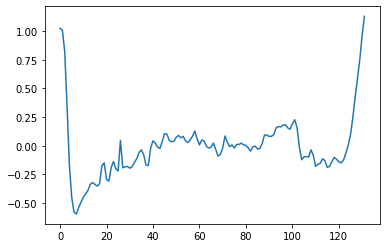

In [3]:
plt.plot(random.choice(beats))
plt.show()

## dataset & dataloader

In [4]:
class BeatDataset(Dataset):
    def __init__(self,datas,labels):
        self.beats = datas
        self.labels = labels
            
    def __getitem__(self,index):
        beat = self.beats[index]
        # (-1,1)
#         beat = (beat-np.min(beat))/(np.max(beat)-np.min(beat))*2-1
        # standardrize
        beat = (beat - np.mean(beat)) / np.std(beat)
        beat = torch.Tensor(np.expand_dims(beat,axis=1))
        downsample = resample(beat,128)
        downsample = np.squeeze(downsample,axis=1)
        label = self.labels[index]
            
        return beat, label, downsample
    
    def __len__(self):
        return len(self.labels)

In [5]:
batch_size = 16
split_ratio = 0.8

dataset = BeatDataset(beats,label)
train_sz = int(len(dataset)*split_ratio)
test_sz = len(dataset)-train_sz
train_set,test_set = random_split(dataset,[train_sz,test_sz])

# rnn_utils.pack_sequence
def collate_fn(batch):
    data = [item[0] for item in batch]
    downsample = torch.Tensor([item[2] for item in batch])
    lengths = torch.Tensor([len(item[0]) for item in batch])
    label = torch.Tensor([item[1] for item in batch])
    data = rnn_utils.pad_sequence(data, batch_first=False, padding_value=0)
    data = rnn_utils.pack_padded_sequence(data,lengths,batch_first=False, enforce_sorted=False)
    return data, label, downsample, lengths

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# for bs, ls, ds, lens in train_loader:
#     print(ds.shape)
# #     test = torch.squeeze(test)
# #     print(test.data.shape)
#     break

## Auto Encoder

In [6]:
class AEmodule(nn.Module):
    def __init__(self):
        super(AEmodule, self).__init__()
        self.input_feature_dim=1
        self.hidden_feature_dim=128
        self.hidden_layer_num=1
        self.latent_size = 32
        self.de_hidden_layer_num = 1
        self.de_hidden_feature_dim = 1
        #---------------------------------------------------------------------------------------
        self.en_lstm = nn.LSTM(self.input_feature_dim, self.hidden_feature_dim, self.hidden_layer_num)
        self.en_linear1 = nn.Linear(self.hidden_feature_dim, self.latent_size)
        #---------------------------------------------------------------------------------------
        self.de_linear1 = nn.Sequential(nn.Linear(self.latent_size, 128),
                                       nn.ReLU())
        self.de_lstm = nn.LSTM(128, self.de_hidden_feature_dim, self.de_hidden_layer_num)
        #---------------------------------------------------------------------------------------
        self.de_linear2 = nn.Sequential(nn.Linear(self.latent_size, 64),
                                       nn.ReLU())
        self.de_linear3 = nn.Sequential(nn.Linear(64, 128))
    
    def encoder_lstm(self,x):
        x,(hn,cn)= self.en_lstm(x)
        hn = torch.squeeze(hn)
        x = self.en_linear1(hn)
        return x,(hn,cn)
    
    def decoder(self,x):
        x = self.de_linear2(x)
        x = self.de_linear3(x)
        return x
    
    def decoder_lstm(self,x, h, lens_unpacked):
        x = self.de_linear1(x)
        x = torch.unsqueeze(x,1)
        x = torch.unsqueeze(x,1)
        # (batch, 1, 1, 256)
        beats = torch.zeros(len(lens_unpacked), max(lens_unpacked), 1).to(x.device)
        for b ,seq_len in enumerate(lens_unpacked):
            # h0=t.randn(self.hidden_layer_num,self.batch_size,self.hidden_feature_dim)
            h = torch.randn(self.de_hidden_layer_num,1,self.de_hidden_feature_dim).to(x.device)
            c = torch.randn(self.de_hidden_layer_num,1,self.de_hidden_feature_dim).to(x.device)
            for i in range(seq_len):
                o,(h,c) = self.de_lstm(x[b],(h,c))
                beats[b,i] = o
        return beats
    
    def forward(self,x,lens_unpacked):
        x, h = self.encoder_lstm(x)
#         x = self.decoder_lstm(x, h, lens_unpacked)
        x = self.decoder(x)
        return x 

## train

In [7]:
learning_rate = 0.001
ae = AEmodule()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
ae.to(device)
optimizer = optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction = 'sum')

cuda:0


loss: 7.139206: 100%|██████████| 30/30 [10:03<00:00, 20.12s/it]  


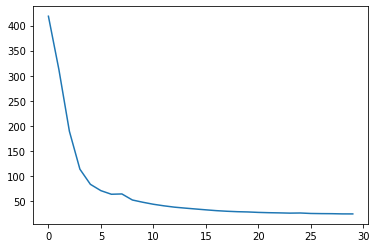

In [8]:
loss_log = []
losses = []
epoch = 30
t = trange(epoch)
for e in t:  # loop over the dataset multiple times   
    for bs, ls, ds, lens in train_loader:
        bs = bs.to(device)
        ds = ds.to(device)
        
        seq_unpacked, lens_unpacked = rnn_utils.pad_packed_sequence(bs, batch_first=True)
        seq_unpacked = seq_unpacked.to(device)
        
        optimizer.zero_grad()
        x = ae.forward(bs,lens_unpacked)
        loss = criterion(x, ds)
        loss.backward()
        optimizer.step()
        
        t.set_description("loss: %f"%loss.item())
        losses.append(loss.item())
        
    loss_log.append(np.mean(losses))
    losses = []
    
plt.plot(loss_log)
plt.show()

## reconstruct test

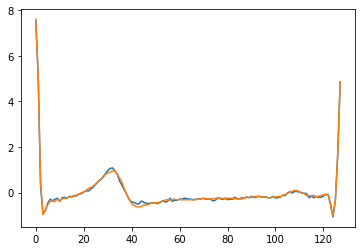

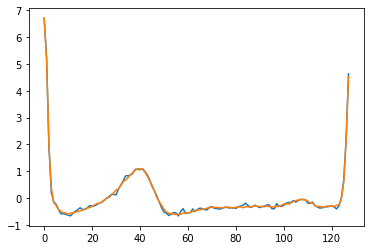

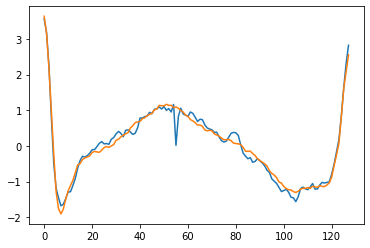

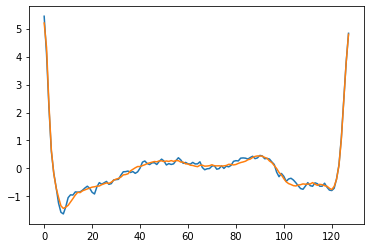

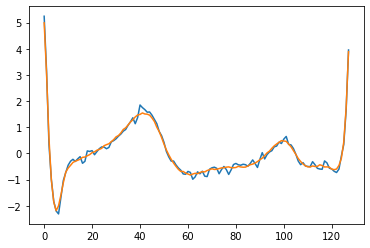

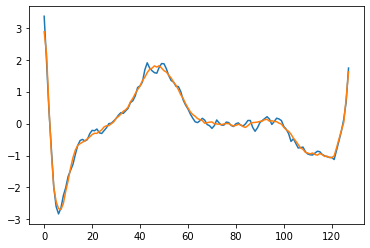

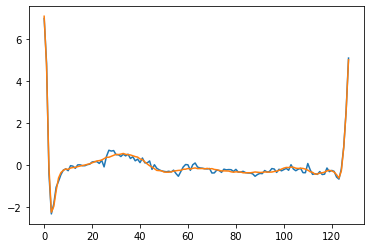

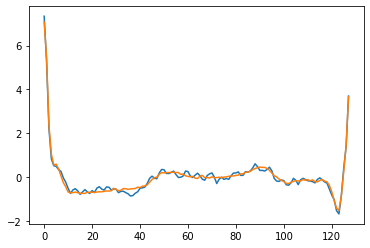

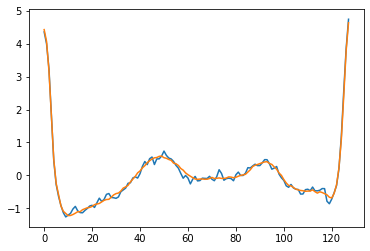

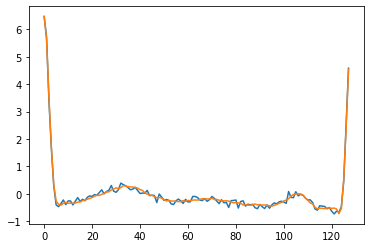

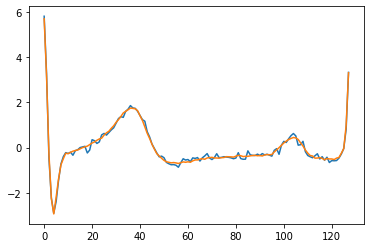

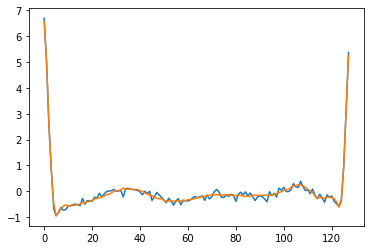

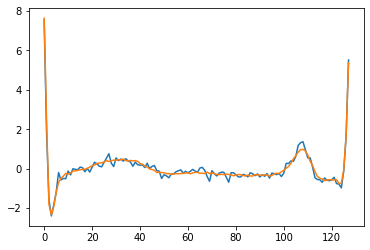

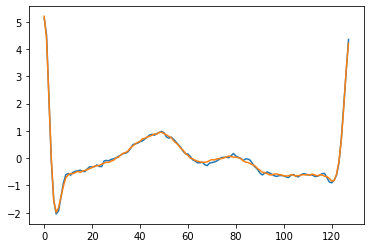

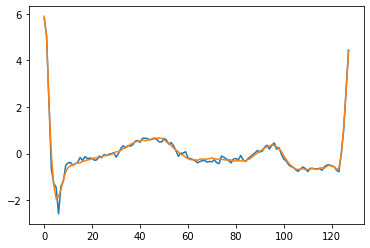

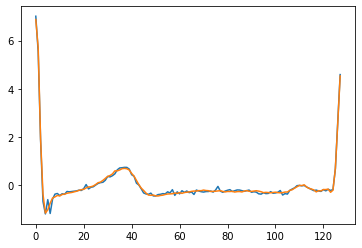

In [9]:
ae.eval()
for bs, ls, ds, lens in test_loader:
    bs = bs.to(device)
    x = ae.forward(bs,lens_unpacked)
    x = x.cpu().detach()
    
    for i in range(ds.shape[0]):
        plt.plot(ds[i])
        plt.plot(x[i])
        plt.show()
    break
        
    